In [ ]:
# install.packages('arrow')
# install.packages('glmmTMB')
# install.packages('DHARMa')
# install.packages('ggplot2')
# install.packages('broom.mixed')
# install.packages('modelsummary')
# install.packages('dplyr')

After filtering to alpha > 3:
       r               alpha            tau             kappa          
 Min.   :   5.00   Min.   :2.679   Min.   :0.1450   Min.   :2.293e+04  
 1st Qu.:  15.25   1st Qu.:2.937   1st Qu.:0.3250   1st Qu.:2.099e+07  
 Median :  61.51   Median :3.195   Median :0.5500   Median :6.766e+07  
 Mean   : 205.15   Mean   :3.324   Mean   :0.5724   Mean   :1.304e+10  
 3rd Qu.: 327.77   3rd Qu.:3.711   3rd Qu.:0.7750   3rd Qu.:4.178e+08  
 Max.   :1000.00   Max.   :3.968   Max.   :1.0000   Max.   :9.013e+12  


Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; false convergence (8). See vignette('troubleshooting'), help('diagnose')”



--- NB2 (mean-only) Model Summary ---
 Family: nbinom2  ( log )
Formula:          kappa ~ alpha:tau:log_r + tau:log_r + alpha:tau
Data: df

     AIC      BIC   logLik deviance df.resid 
 9038787  9038839 -4519388  9038777   239995 


Dispersion parameter for nbinom2 family ():   12 

Conditional model:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     15.328172   0.001408   10886   <2e-16 ***
tau:log_r       -1.963090   0.001611   -1218   <2e-16 ***
tau:alpha        0.104096   0.001001     104   <2e-16 ***
tau:log_r:alpha  0.981421   0.000506    1941   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; false convergence (8). See vignette('troubleshooting'), help('diagnose')”



--- NB2 (mean + dispformula) Model Summary ---
 Family: nbinom2  ( log )
Formula:          kappa ~ alpha:tau:log_r + tau:log_r + alpha:tau
Dispersion:             
~alpha * tau * log_r - alpha - tau:log_r - log_r - tau - 1
Data: df

     AIC      BIC   logLik deviance df.resid 
 8972080  8972153 -4486033  8972066   239993 


Conditional model:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     15.373879   0.000758   20287   <2e-16 ***
tau:log_r       -2.040115   0.001467   -1390   <2e-16 ***
tau:alpha        0.077418   0.000809      96   <2e-16 ***
tau:log_r:alpha  1.003808   0.000429    2342   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Dispersion model:
                Estimate Std. Error z value Pr(>|z|)    
alpha:tau        0.77352    0.00376     206   <2e-16 ***
alpha:log_r      0.28851    0.00048     602   <2e-16 ***
alpha:tau:log_r -0.34407    0.00112    -306   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0

DHARMa:testOutliers with type = binomial may have inflated Type I error rates for integer-valued distributions. To get a more exact result, it is recommended to re-run testOutliers with type = 'bootstrap'. See ?testOutliers for details




Overdispersion test:


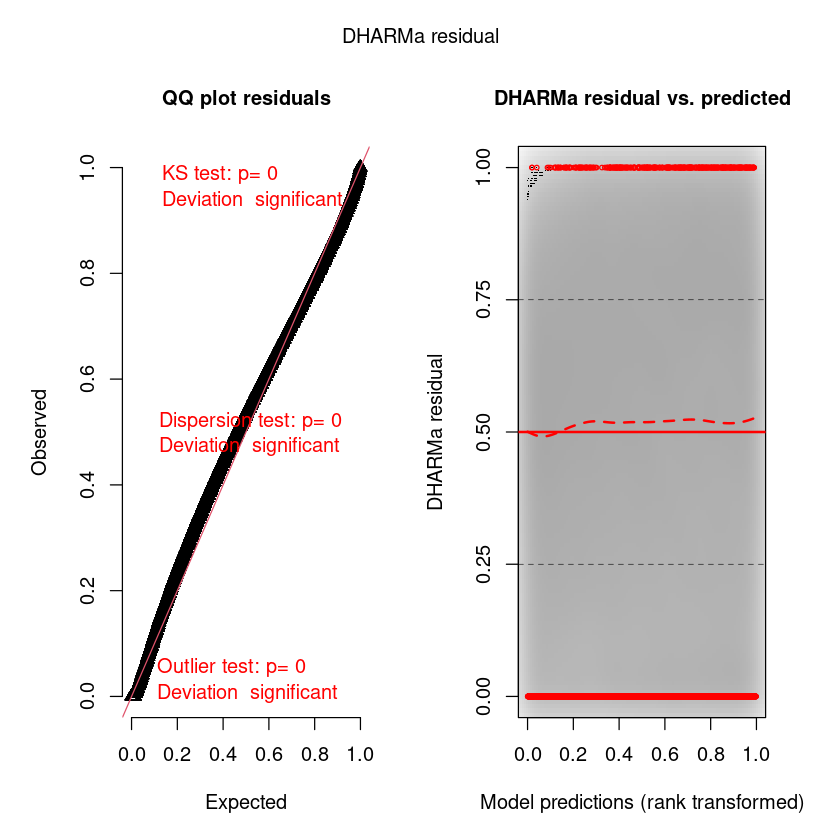


	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
dispersion = 0.52249, p-value < 2.2e-16
alternative hypothesis: two.sided


Zero-inflation test:


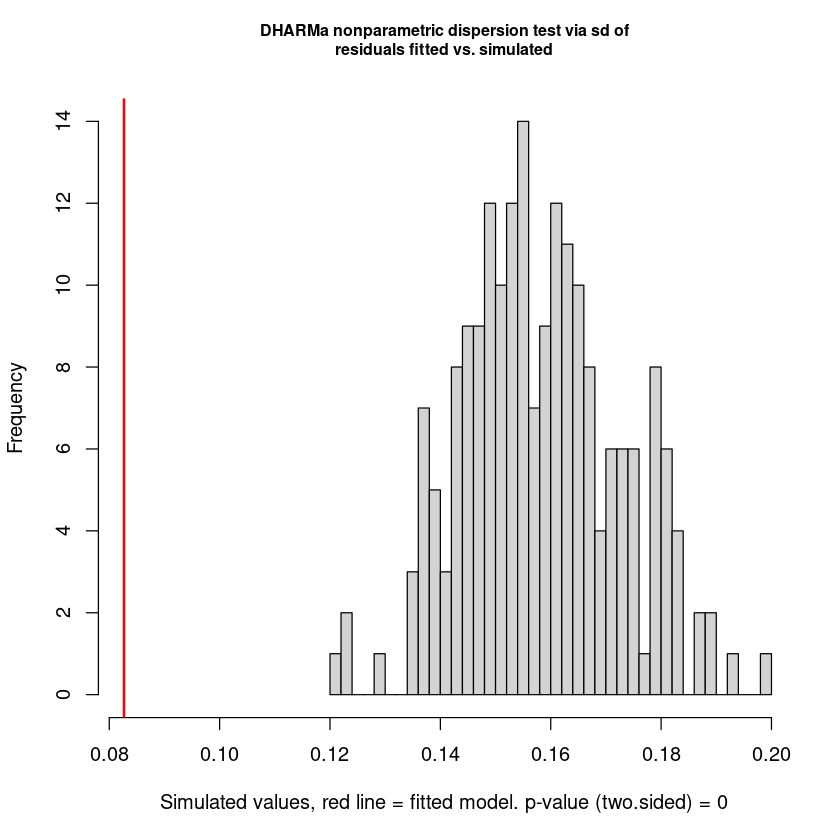


	DHARMa zero-inflation test via comparison to expected zeros with
	simulation under H0 = fitted model

data:  simulationOutput
ratioObsSim = NaN, p-value = 1
alternative hypothesis: two.sided


--- Compare mean-only vs. disp formula model via AIC ---
             df     AIC
fit_nb2_mean  5 9038787
fit_nb2_disp  7 8972080

--- Generating Prediction DataFrame (varying r) ---

--- Plot: Predicted Kappa vs. r ---


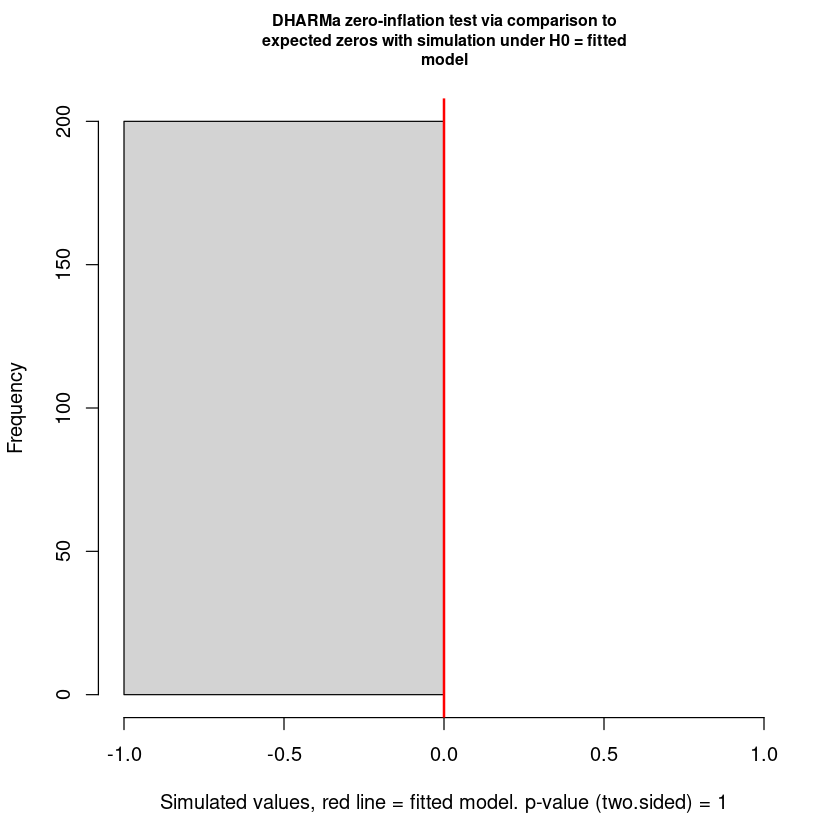

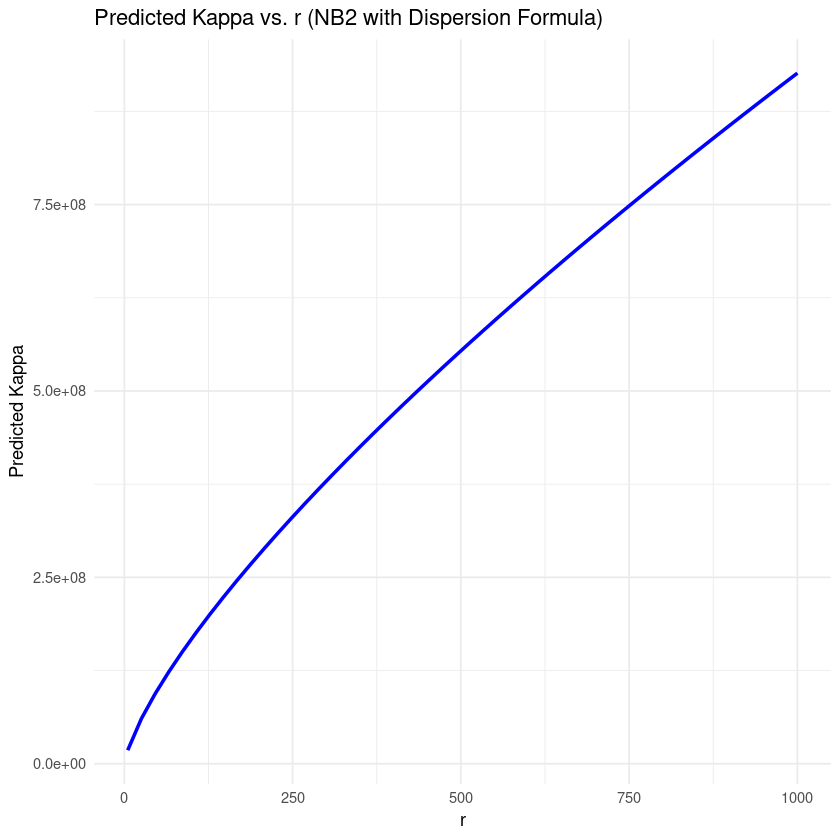

In [2]:
###########################################################
# 0) Install (if needed) and load required packages
###########################################################
# Uncomment the line below if you need to install packages:
# install.packages(c("arrow", "dplyr", "glmmTMB", "DHARMa", 
#                    "ggplot2", "broom.mixed", "modelsummary"))

library(arrow)      
library(dplyr)      # for data manipulation (group_by, summarise, etc.)
library(glmmTMB)    
library(DHARMa)     
library(ggplot2)    
library(broom.mixed)   
library(modelsummary)

###########################################################
# 1) Read data from a Parquet file & filter alpha > 3
###########################################################
data_file <- "/data/saturation/thesis_run_20250108/kappa_simulation_results.parquet"
df <- read_parquet(data_file)

# Filter to alpha > 3
df <- df %>% filter(alpha >= 2.5) %>% filter(alpha <= 4)
df <- sample_frac(df, 0.1)

# Quick look
cat("After filtering to alpha > 3:\n")
print(summary(df))

###########################################################
# 2) Prepare log(r)
###########################################################
df$log_r <- log(df$r)
df$alpha_minus_2 <- df$alpha - 2
df$mod_alpha <- (df$alpha - 2) / df$alpha / exp(df$alpha)

###########################################################
# 3) Exploratory: OLS variance modeling
#    We have repeated measures of kappa for each (r, alpha, tau).
#    We'll group by these predictors, compute empirical mean & var,
#    then fit an OLS to see how log(var) depends on log(mean) and others.
###########################################################

# # Step 3a) Group by (r, alpha, tau), compute mean & var of kappa
# dfSumm <- df %>%
#   group_by(r, alpha, tau) %>%
#   summarise(
#     kappa_mean = mean(kappa),
#     kappa_var  = var(kappa),
#     .groups    = "drop"
#   ) %>%
#   mutate(
#     log_kappa_mean = log(kappa_mean),
#     log_kappa_var  = log(kappa_var),
#     log_r          = log(r)  # re-create log_r at group level
#   )

# # Step 3b) Fit OLS model for log(kappa_var):
# #          log(kappa_var) ~ log(kappa_mean) + log(r):alpha + log(kappa_mean):tau + log(r):alpha:tau - 1
# lm_variance <- lm(
#   log_kappa_var ~ -1 + log_kappa_mean + log_r:alpha + log_kappa_mean:tau + log_r:alpha:tau,
#   data = dfSumm
# )

# cat("\n--- OLS Variance Model Summary ---\n")
# print(summary(lm_variance))

###########################################################
# 4) Fit NB2 models in glmmTMB
###########################################################

# 4a) NB2 with specified mean structure:
#     log(kappa) ~ 1 + alpha:tau:log_r + tau:log_r + alpha
fit_nb2_mean <- glmmTMB(
  kappa ~ alpha:tau:log_r + tau:log_r + alpha:tau,
  data    = df,
  family  = nbinom2(link = "log"),
)

cat("\n--- NB2 (mean-only) Model Summary ---\n")
print(summary(fit_nb2_mean), digits = 3)

# 4b) NB2 with predictor-dependent dispersion 
fit_nb2_disp <- glmmTMB(
  kappa ~ alpha:tau:log_r + tau:log_r + alpha:tau,
  dispformula = ~ alpha*tau*log_r - alpha - tau:log_r - log_r - tau - 1,  
  data        = df,
  family      = nbinom2(link = "log")
)

cat("\n--- NB2 (mean + dispformula) Model Summary ---\n")
print(summary(fit_nb2_disp), digits = 3)

###########################################################
# 5) Diagnostics with DHARMa (for the disp model)
###########################################################
cat("\n--- DHARMa Diagnostics: NB2 with Dispersion Formula ---\n")
res_nb2_disp <- simulateResiduals(fit_nb2_disp, n = 200)
plot(res_nb2_disp)

cat("\nOverdispersion test:\n")
print(testDispersion(res_nb2_disp))

cat("\nZero-inflation test:\n")
print(testZeroInflation(res_nb2_disp))

###########################################################
# 6) Compare models (AIC)
###########################################################
cat("\n--- Compare mean-only vs. disp formula model via AIC ---\n")
print(AIC(fit_nb2_mean, fit_nb2_disp))

###########################################################
# 7) Optional: Inspect predictions from the disp model
###########################################################
cat("\n--- Generating Prediction DataFrame (varying r) ---\n")
pred_data <- data.frame(
  alpha = mean(df$alpha),
  tau   = mean(df$tau),
  r     = seq(min(df$r), max(df$r), length.out = 50)
)
pred_data$log_r <- log(pred_data$r)

# Predict kappa (type = "response")
pred_data$kappa_pred <- predict(fit_nb2_disp, newdata = pred_data, type = "response")

# Plot
cat("\n--- Plot: Predicted Kappa vs. r ---\n")
ggplot(pred_data, aes(x = r, y = kappa_pred)) +
  geom_line(color = "blue", size = 1) +
  labs(
    title = "Predicted Kappa vs. r (NB2 with Dispersion Formula)",
    x     = "r",
    y     = "Predicted Kappa"
  ) +
  theme_minimal()

In [ ]:
summary(df)
any(is.infinite(df$log_r))
any(is.na(df$log_r))

In [ ]:
fit_nb2_disp$fit$convergence
fit_nb2_disp$fit$message